# Import libraries

In [41]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from arima import ARIMA
import quantnn

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import run_experiment

np.random.seed(500)
import torch
torch.manual_seed(500)
import random
random.seed(500)

In [2]:
dataset = "synthetic"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [4]:
df

t          y      y_lag     y_diff  y_diff_lag
0        0  15.042543  11.899683   3.142860    5.073400
1        1  21.174105  15.042543   6.131562    3.142860
2        2  15.639777  21.174105  -5.534328    6.131562
3        3  16.058487  15.639777   0.418709   -5.534328
4        4  10.058106  16.058487  -6.000381    0.418709
...    ...        ...        ...        ...         ...
2993  2993  83.961128  81.979873   1.981255    7.443323
2994  2994  80.244640  83.961128  -3.716488    1.981255
2995  2995  86.632633  80.244640   6.387993   -3.716488
2996  2996  89.318904  86.632633   2.686271    6.387993
2997  2997  74.585500  89.318904 -14.733404    2.686271

[2998 rows x 5 columns]

## ARIMA

In [5]:
predictions, df_arima = run_experiment.experiment_arima(df, T)

Start forecasting


100%|██████████| 600/600 [57:05<00:00,  5.71s/it]    


<Figure size 640x480 with 0 Axes>

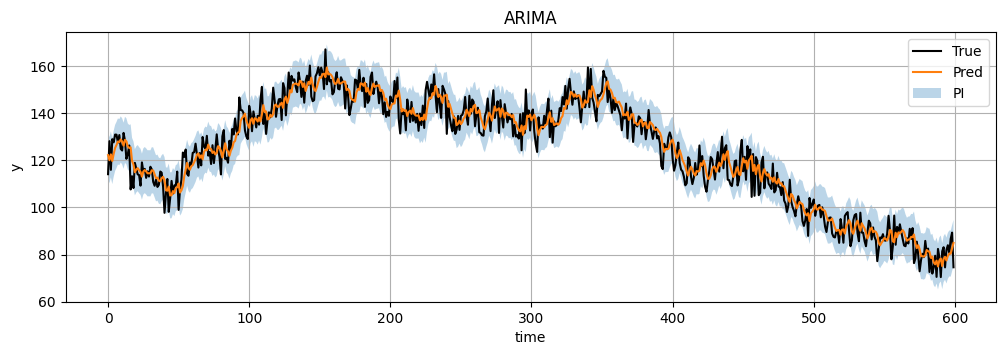

In [6]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["pred"].to_numpy(),
               PI_low = predictions["lower_bound"].to_numpy(), PI_hi =  predictions["upper_bound"].to_numpy(), conf_PI_low=None, conf_PI_hi=None,
               x_label="time", y_label="y", title='ARIMA')

In [7]:
# df_arima

## Linear regression

Define metrics

In [8]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [9]:
predictions = []  # to store different predictions

Quantile estimation

(2998, 3)


Text(0.5, 0, 'time')

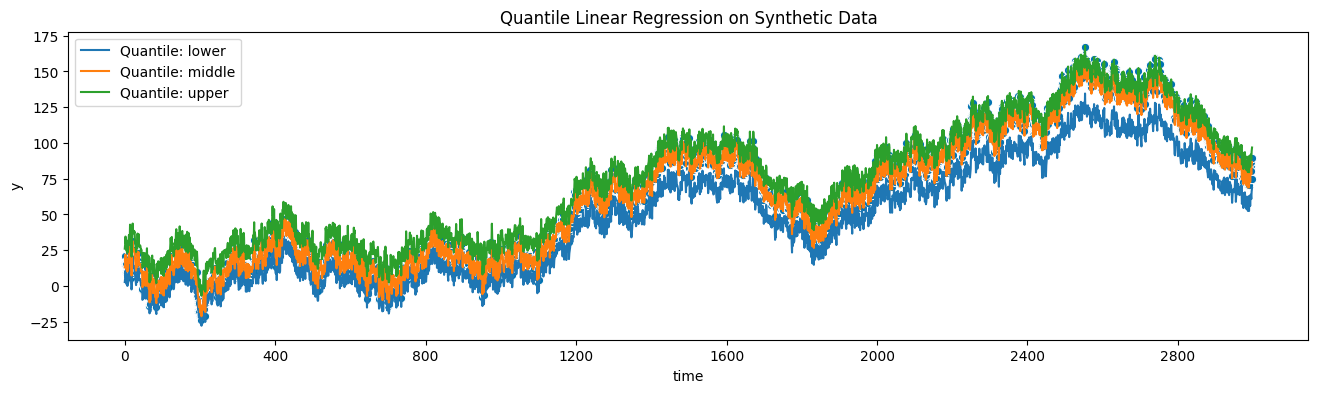

In [10]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values())
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)
plt.title("Quantile Linear Regression on Synthetic Data")
plt.xlabel("time")

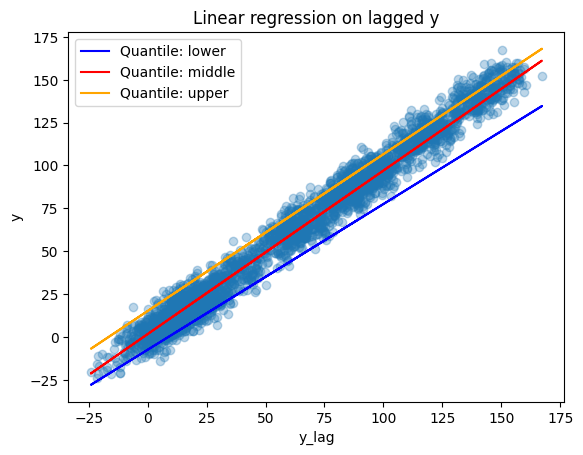

In [11]:
# this cell is to show the correlation between y_lag and y
plt.scatter(df["y_lag"], df["y"], alpha=0.3)
plt.plot(df["y_lag"], QLR_predictions["lower"].flatten(), color="blue",  label="Quantile: lower")

plt.plot(df["y_lag"], QLR_predictions["middle"].flatten(), color="red", label="Quantile: middle")
plt.plot(df["y_lag"], QLR_predictions["upper"].flatten(), color="orange", label="Quantile: upper")


plt.title("Linear regression on lagged y")
plt.xlabel("y_lag")
plt.ylabel("y")
plt.legend()
plt.show()

CQR

  0%|          | 0/600 [00:00<?, ?it/s]

[18:13:34] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=92277;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=713;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

100%|██████████| 600/600 [00:55<00:00, 10.85it/s]


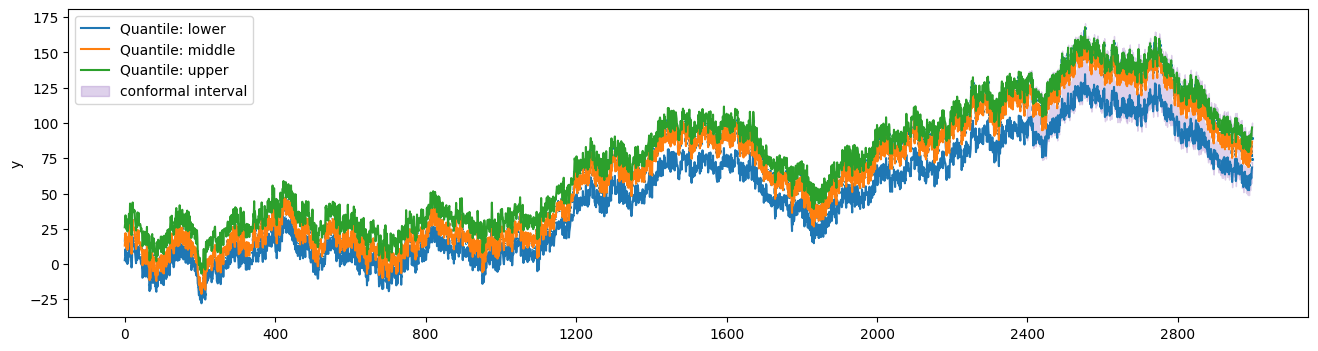

In [12]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[0] = metric.computeAll(model_name="Linear CQR").values()

<Figure size 640x480 with 0 Axes>

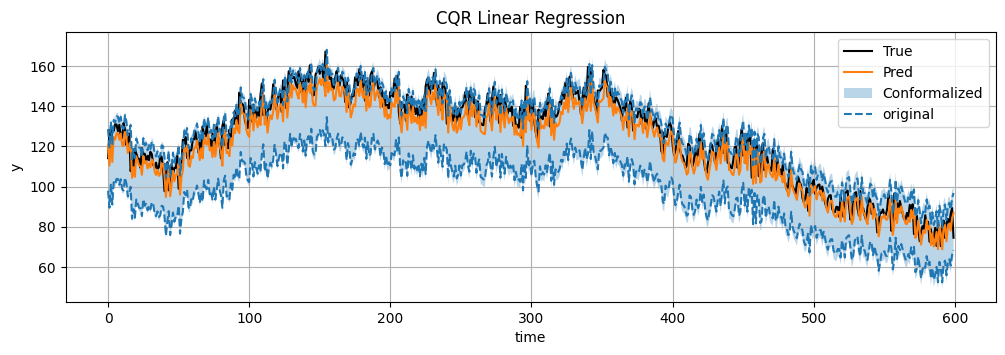

In [13]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Linear Regression')

ACI

100%|██████████| 600/600 [00:02<00:00, 231.54it/s]


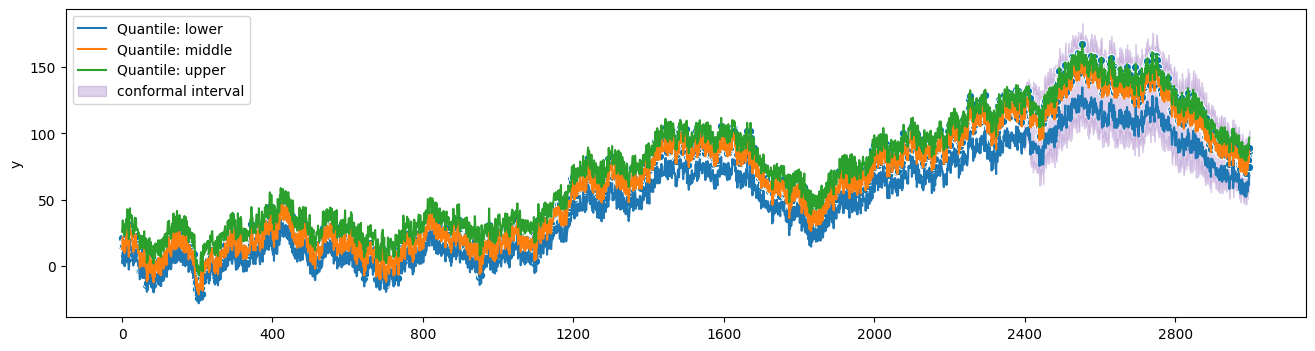

In [14]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[1] = metric.computeAll(model_name="Linear ACI").values()

CQR and ACI plots

<Figure size 640x480 with 0 Axes>

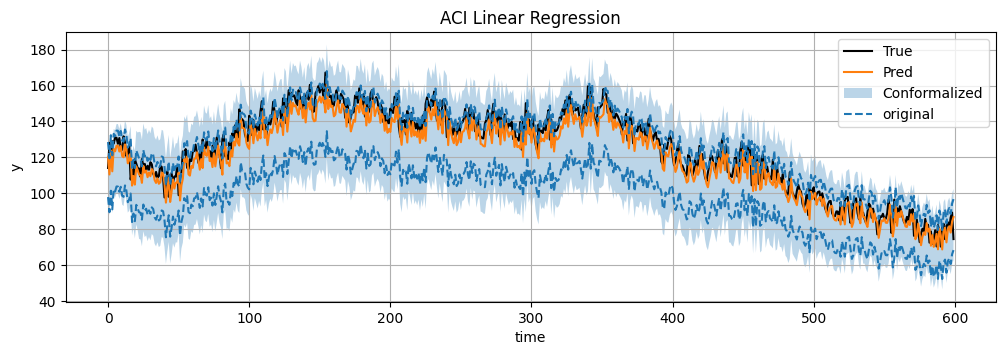

In [15]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Linear Regression')

EnbPI

In [16]:
X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), 
                              df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
X_bootstrap.shape

(2398, 1)

In [17]:
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])
y_bootstrap.shape

(2398,)

In [18]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

batch: 0 batch: 1 batch: 2 batch: 3 batch: 4 batch: 5 batch: 6 batch: 7 batch: 8 batch: 9 batch: 10 batch: 11 batch: 12 batch: 13 batch: 14 batch: 15 batch: 16 batch: 17 batch: 18 batch: 19 

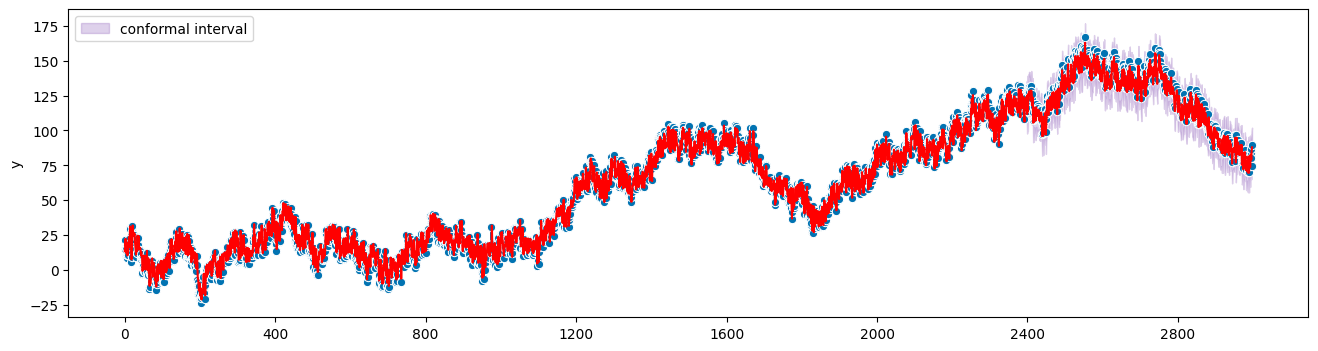

In [19]:
model = QuantileLinearRegressor(quantiles=[0.5])

bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                        bs_train_data=bs_train_data,
                                        X_train=X_bootstrap,
                                        X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"]], conformal_intervals[:,0], conformal_intervals[:,1],)
df_linear.loc[2] = metric.computeAll(model_name="Linear EnbPI").values()

In [20]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  8.045551  0.856667  36.973091  0.381919  0.584225
1    Linear ACI  8.045551  0.996667  57.049297  0.589299  0.310298
2  Linear EnbPI  7.439092  0.945000  28.235654  0.291664  0.666586

<Figure size 640x480 with 0 Axes>

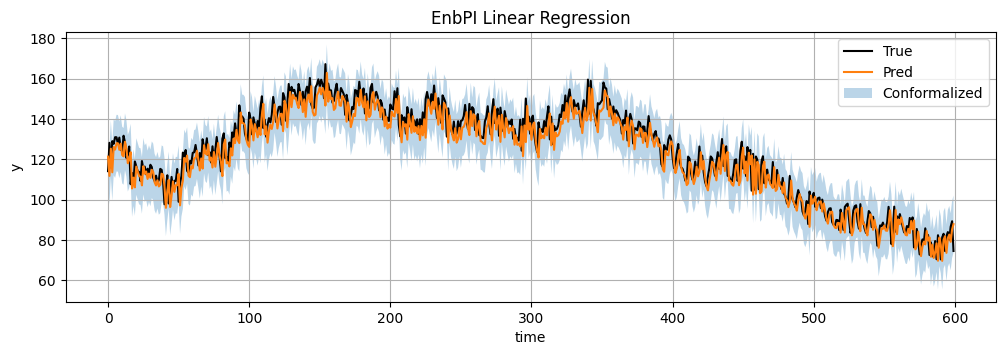

In [21]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Linear Regression')

In [22]:

def local_coverage(y_test, y_lower, y_upper , interval: tuple[int, int]):
    """Compute coverage for a specified interval."""
    l, r = interval
    not_covered = ~((y_test[l:r] >= y_lower[l:r]) & (y_test[l:r] <= y_upper[l:r]))

    return 1 - np.mean(not_covered)


local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (0,200))

0.955

In [23]:
len(df)

2998

In [24]:
# we have a test set of 600 samples, so we use a local window of 20 samples
covs = []
for i in range(10, 600):
    cov = local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (i-10,i))
    covs.append(cov)

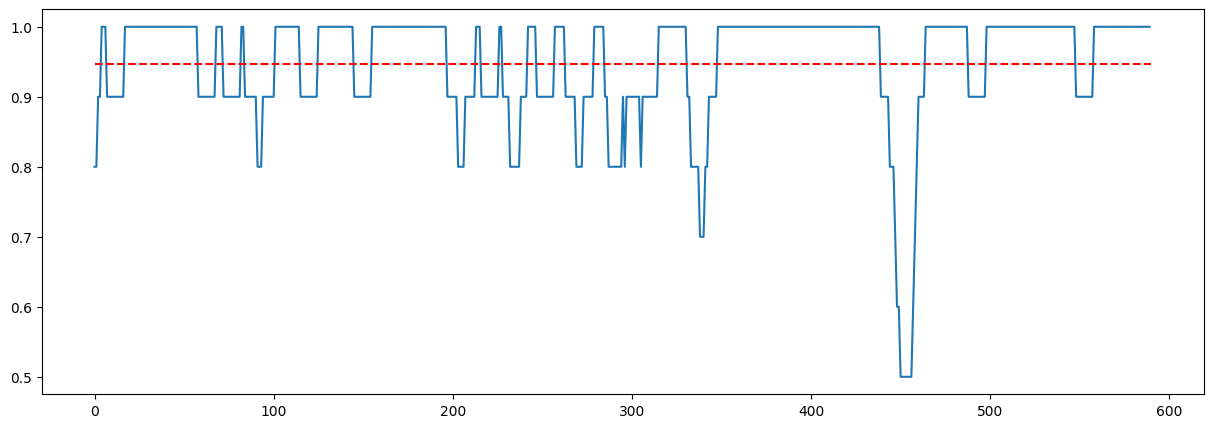

0.9464406779661017


In [25]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(covs)
# create dashed mean plot
ax.plot([0, len(covs)], [np.mean(covs), np.mean(covs)], linestyle="--", color="red")
plt.show()
print(np.mean(covs))

EnCQR

In [26]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [27]:
model = QuantileLinearRegressor(quantiles=[0.05, 0.5, 0.95])
epsilon_low, epsilon_hi = encqr.train(df_train, train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 Training model for Sb: 1 Training model for Sb: 2 

In [28]:
test_label = df_test["y"].to_numpy()

In [29]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2


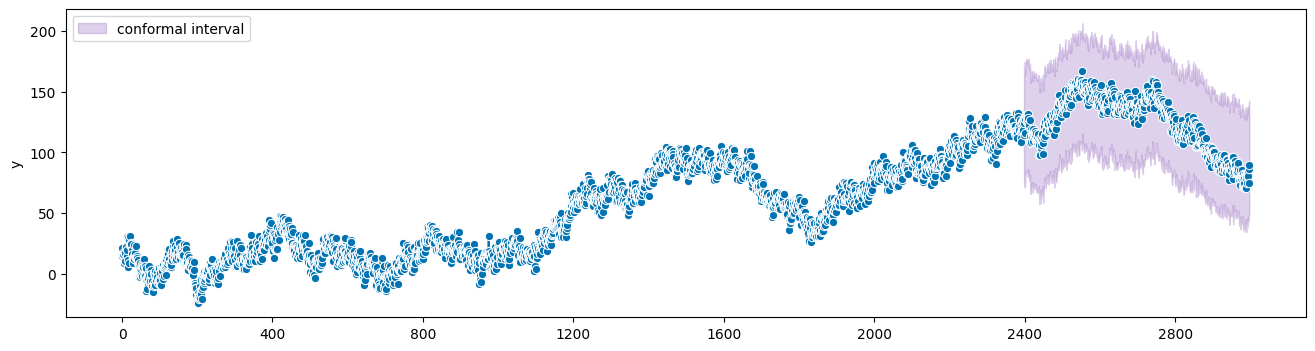

In [30]:

encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_linear.loc[3] = metric.computeAll(model_name="Linear EnCQR").values()

<Figure size 640x480 with 0 Axes>

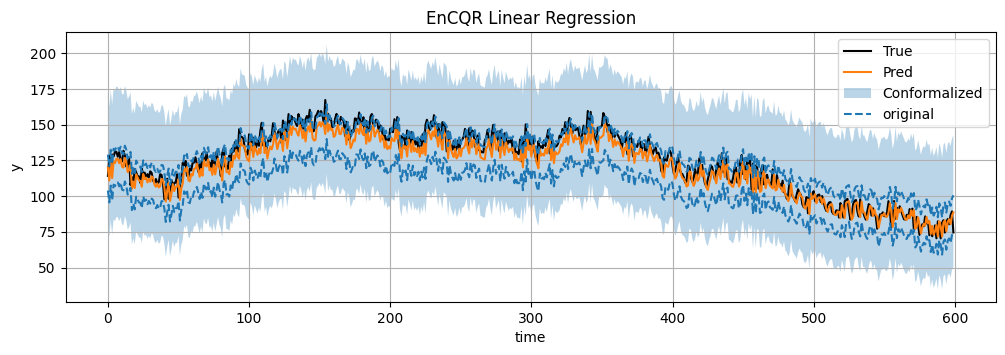

In [31]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Linear Regression')

In [32]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  8.045551  0.856667  36.973091  0.381919  0.584225
1    Linear ACI  8.045551  0.996667  57.049297  0.589299  0.310298
2  Linear EnbPI  7.439092  0.945000  28.235654  0.291664  0.666586
3  Linear EnCQR  8.212838  1.000000  91.289444  0.942987  0.042236

Plot testing

In [33]:
def local_cov(y_test, y_lower, y_upper):
    not_covered = ~((y_test >= y_lower) & (y_test <= y_upper))
    
    return 1 - np.mean(not_covered)


local_cov(df_test["y"].to_numpy(), conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten())

1.0

## Quantile Forest

Define metrics

In [34]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [35]:
predictions = []

Quantile estimation

In [36]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [37]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2)
QFR.fit(X_train, y_train)

In [38]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

2998it [00:17, 171.94it/s]


In [39]:
y_pred.shape

(2998, 3)

In [40]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

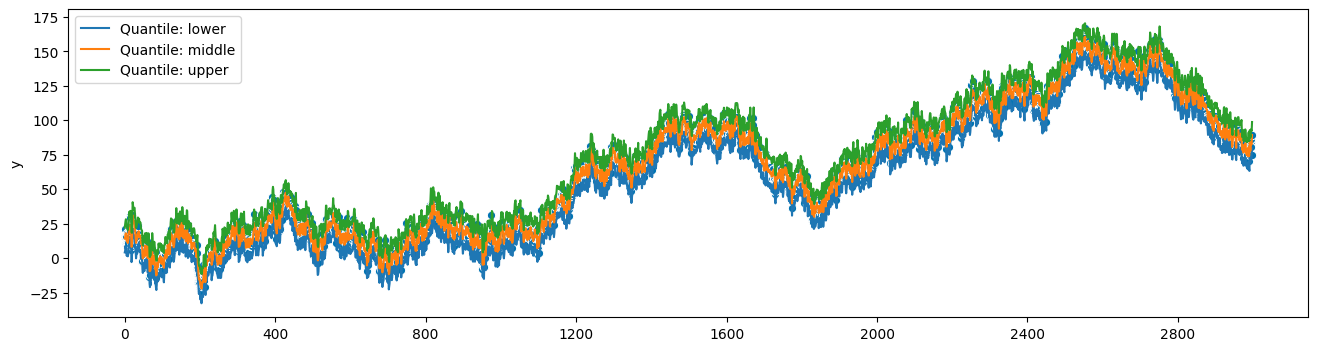

In [41]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

CQR

100%|██████████| 600/600 [00:01<00:00, 597.49it/s]


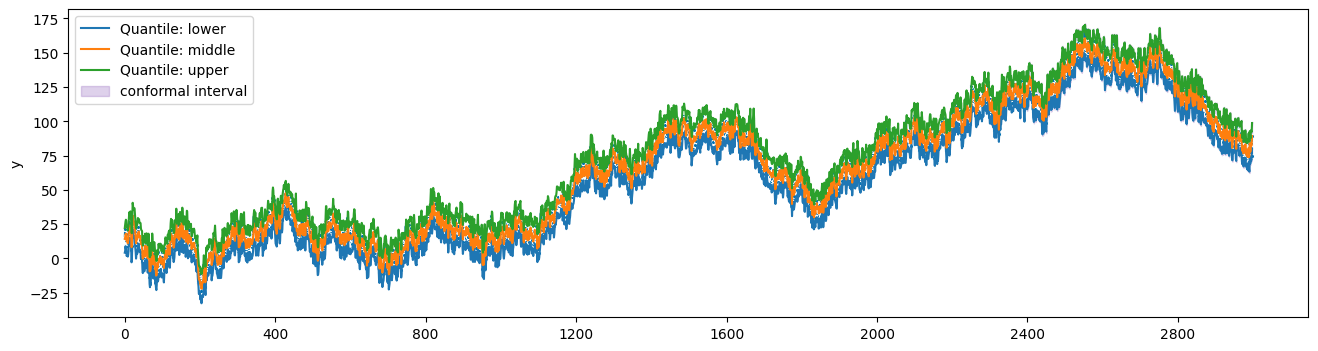

In [42]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[0] = metric.computeAll(model_name="Forest CQR").values()

<Figure size 640x480 with 0 Axes>

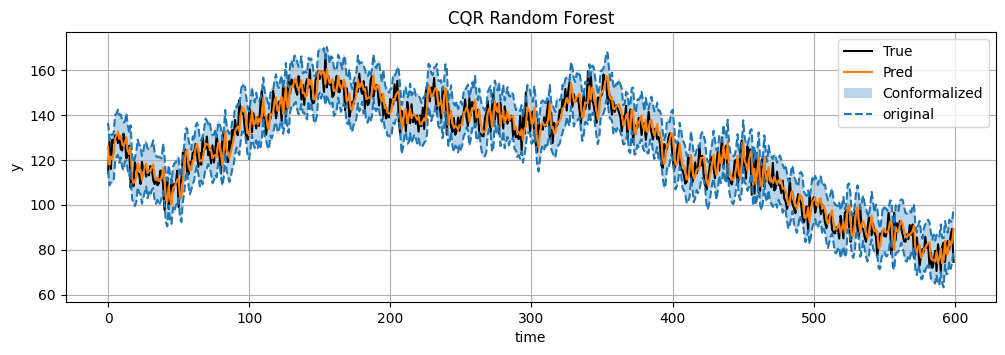

In [43]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Random Forest')

ACI

100%|██████████| 600/600 [00:02<00:00, 267.56it/s]


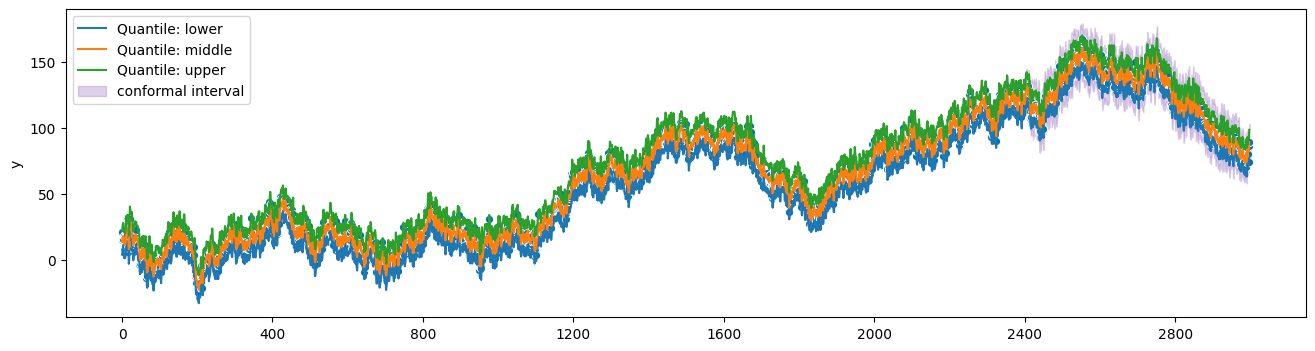

In [44]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[1] = metric.computeAll(model_name="Forest ACI").values()

<Figure size 640x480 with 0 Axes>

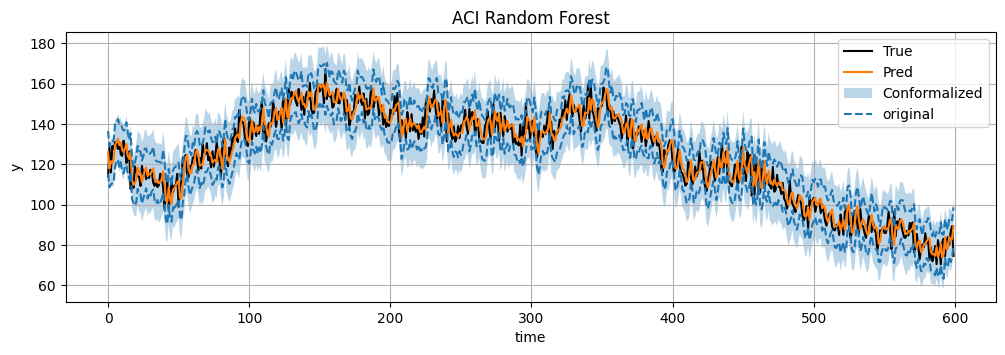

In [45]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Random Forest')

## EnbPI

In [46]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([X_train, X_val], axis=0)
y_bootstrap = np.concatenate([y_train, y_val])

# train data is y_diff_lag and y_diff to predict eventually y
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [47]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.5], max_depth=2)

# we train on y diff lag and predict on X bootstrap and X test (both diff lag)
bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=X_test)

batch: 0 

2998it [00:17, 174.98it/s]


batch: 1 

2998it [00:17, 175.59it/s]


batch: 2 

2998it [00:16, 176.75it/s]


batch: 3 

2998it [00:17, 175.86it/s]


batch: 4 

2998it [00:17, 176.28it/s]


batch: 5 

2998it [00:16, 176.95it/s]


batch: 6 

2998it [00:16, 176.49it/s]


batch: 7 

2998it [00:16, 176.74it/s]


batch: 8 

2998it [00:16, 177.28it/s]


batch: 9 

2998it [00:17, 175.12it/s]


batch: 10 

2998it [00:18, 161.71it/s]


batch: 11 

2998it [00:17, 166.87it/s]


batch: 12 

2998it [00:18, 165.06it/s]


batch: 13 

2998it [00:18, 166.37it/s]


batch: 14 

2998it [00:18, 159.51it/s]


batch: 15 

2998it [00:18, 165.76it/s]


batch: 16 

2998it [00:17, 167.55it/s]


batch: 17 

2998it [00:17, 166.62it/s]


batch: 18 

2998it [00:17, 167.72it/s]


batch: 19 

2998it [00:18, 158.06it/s]


In [48]:
df_train_val = pd.concat([df_train, df_val], axis=0)

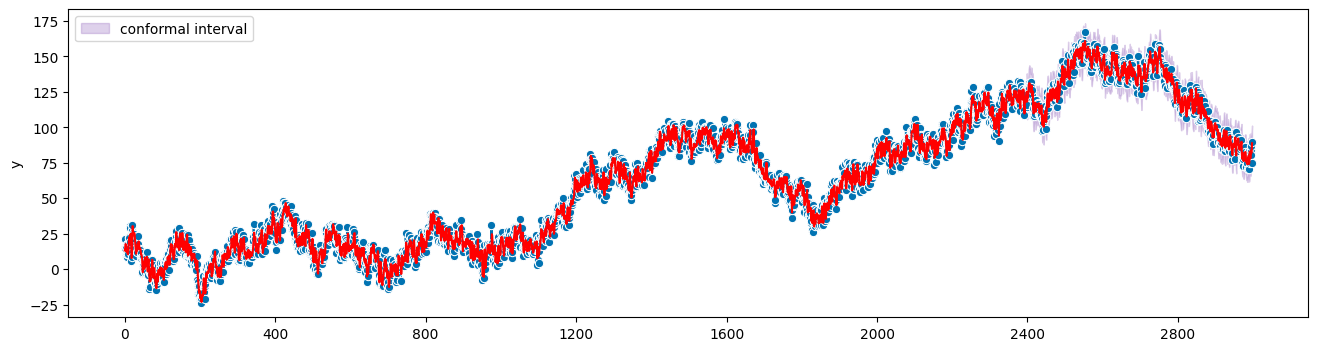

In [49]:

# based on the diff lag predictions and actual
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=df_train_val["y"].to_numpy(),
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_forest.loc[2] = metric.computeAll(model_name="Forest EnbPI").values()

<Figure size 640x480 with 0 Axes>

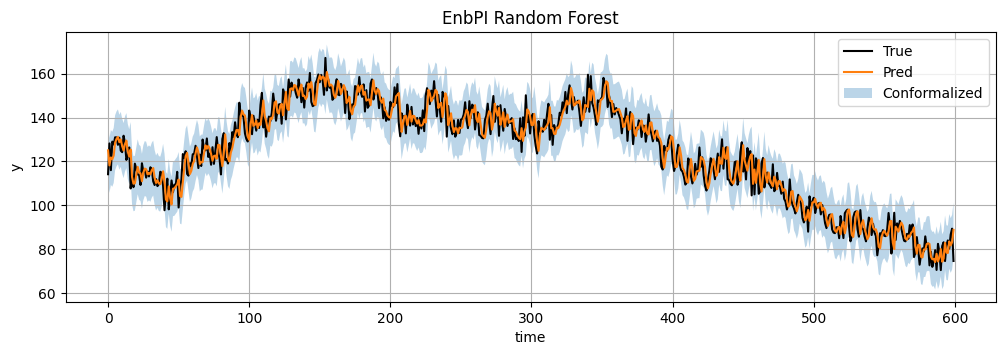

In [50]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Random Forest')

EnCQR

In [51]:
df_train

t          y      y_lag    y_diff  y_diff_lag
0        0  15.042543  11.899683  3.142860    5.073400
1        1  21.174105  15.042543  6.131562    3.142860
2        2  15.639777  21.174105 -5.534328    6.131562
3        3  16.058487  15.639777  0.418709   -5.534328
4        4  10.058106  16.058487 -6.000381    0.418709
...    ...        ...        ...       ...         ...
1793  1793  52.618387  61.657058 -9.038672    6.100988
1794  1794  56.376798  52.618387  3.758412   -9.038672
1795  1795  62.303944  56.376798  5.927145    3.758412
1796  1796  62.646629  62.303944  0.342685    5.927145
1797  1797  60.979271  62.646629 -1.667358    0.342685

[1798 rows x 5 columns]

In [52]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test, differencing=True)


In [53]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2)

epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 

799it [00:04, 177.20it/s]
799it [00:05, 157.04it/s]


Training model for Sb: 1 

799it [00:05, 156.34it/s]
799it [00:05, 137.50it/s]


Training model for Sb: 2 

799it [00:04, 161.35it/s]
799it [00:04, 166.52it/s]


In [54]:
test_y.shape

(600,)

In [55]:
test_x.shape

(600, 1)

In [56]:
len(df_train) + len(df_val)

2398

In [57]:
test_label = df_test["y"].to_numpy()

In [58]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label, test_start=2398)

Creating test predictions for Sb 0


600it [00:03, 173.76it/s]


Creating test predictions for Sb 1


600it [00:03, 175.09it/s]


Creating test predictions for Sb 2


600it [00:03, 175.48it/s]


<Figure size 640x480 with 0 Axes>

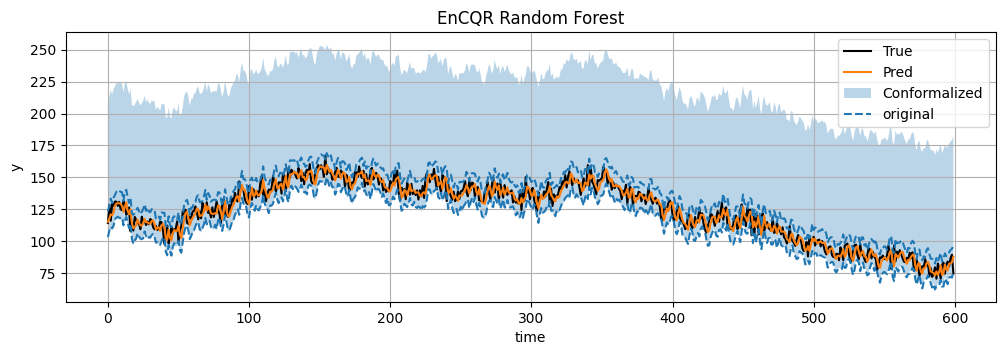

In [59]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Random Forest')

<Figure size 640x480 with 0 Axes>

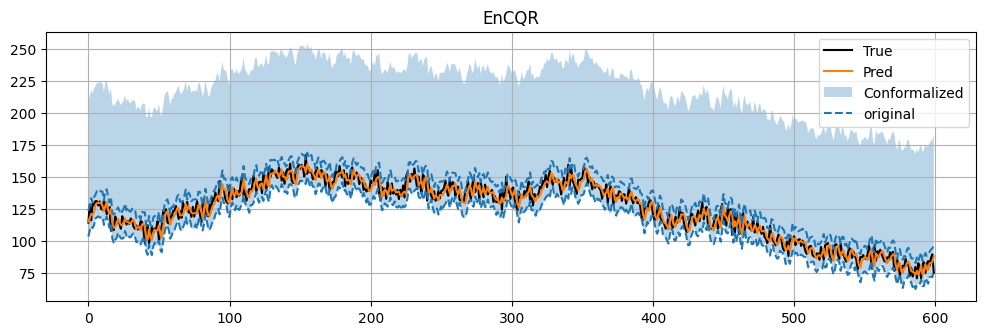

In [60]:
# Plot original and conformalized PI
encqr.plot_PIs(df_test["y"].to_numpy(), PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

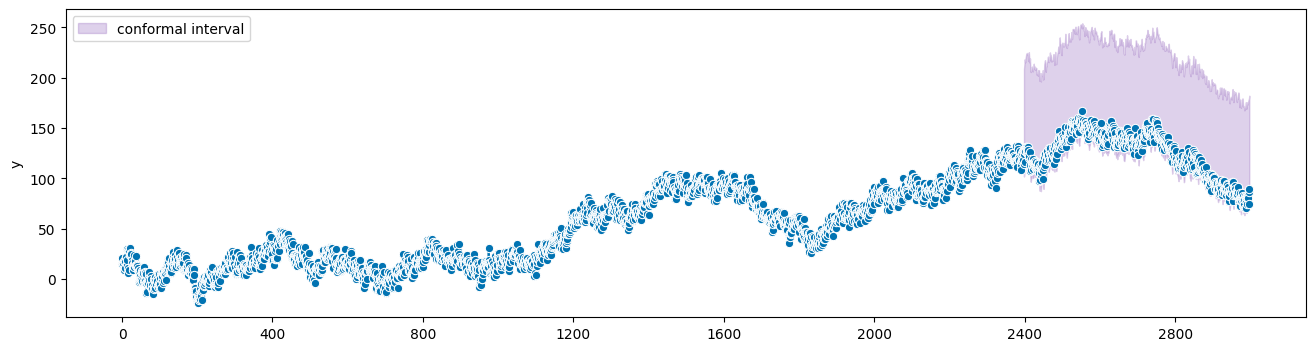

In [61]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_forest.loc[3] = metric.computeAll(model_name="Forest EnCQR").values()

In [62]:
df_forest

model_name      RMSE      PICP        PIAW     PINAW       CWC
0    Forest CQR  6.475906  0.911667   22.232660  0.229655  0.767206
1    Forest ACI  6.475906  0.993333   37.673893  0.389158  0.470363
2  Forest EnbPI  6.342553  0.955000   25.061963  0.258881  0.676824
3  Forest EnCQR  6.351601  0.971667  106.359196  1.098652 -0.084564

## Neural Regression with QRNN

Define metrics

In [42]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [43]:
predictions = []

In [44]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [45]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [46]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.286        
      2   0.0005         2.989        
      3   0.0005         2.237        
      4   0.0005         1.835        
      5   0.0005         1.760        
      6   0.0005         1.745        
      7   0.0005         1.721        
      8   0.0005         1.681        
      9   0.0005         1.631        
     10   0.0005         1.550        
     11   0.0005         1.487        
     12   0.0005         1.451        
     13   0.0005         1.450        
     14   0.0005         1.434        
     15   0.0005         1.433

In [47]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


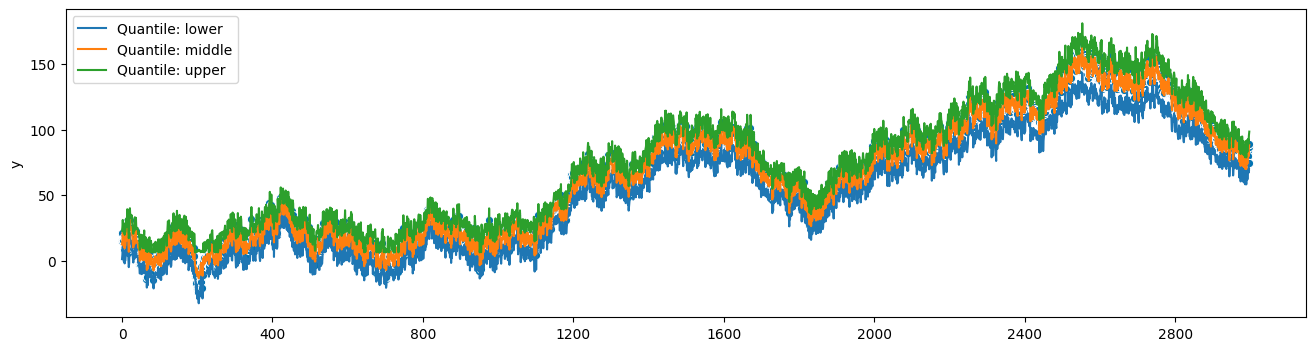

In [48]:
qrnn.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions)

CQR

100%|██████████| 600/600 [00:01<00:00, 489.59it/s]


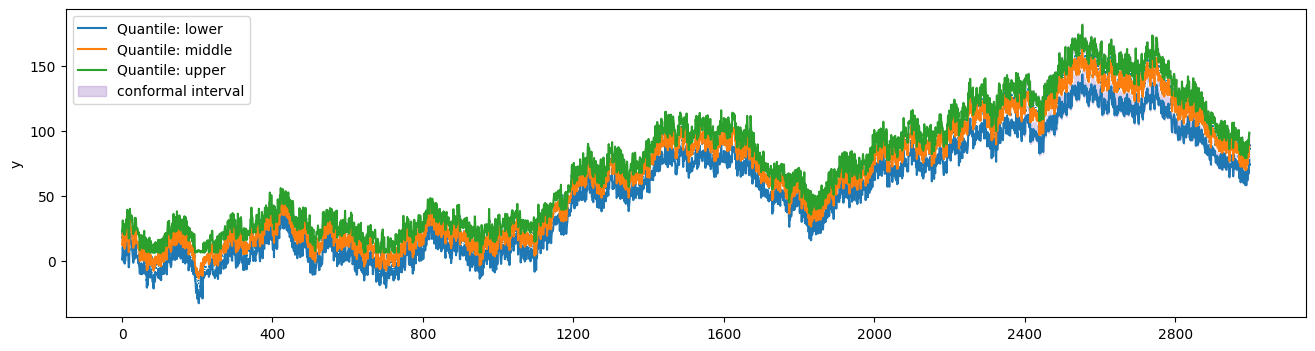

In [49]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[0] = metric.computeAll(model_name="NN CQR").values()

<Figure size 640x480 with 0 Axes>

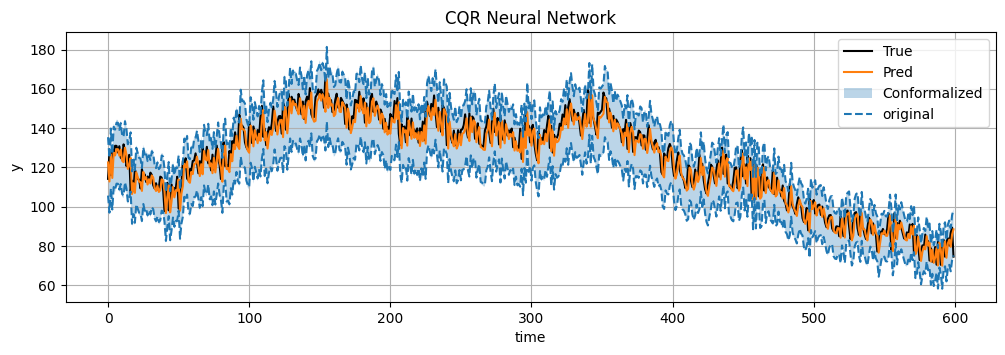

In [50]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Neural Network')

ACI

100%|██████████| 600/600 [00:02<00:00, 227.05it/s]


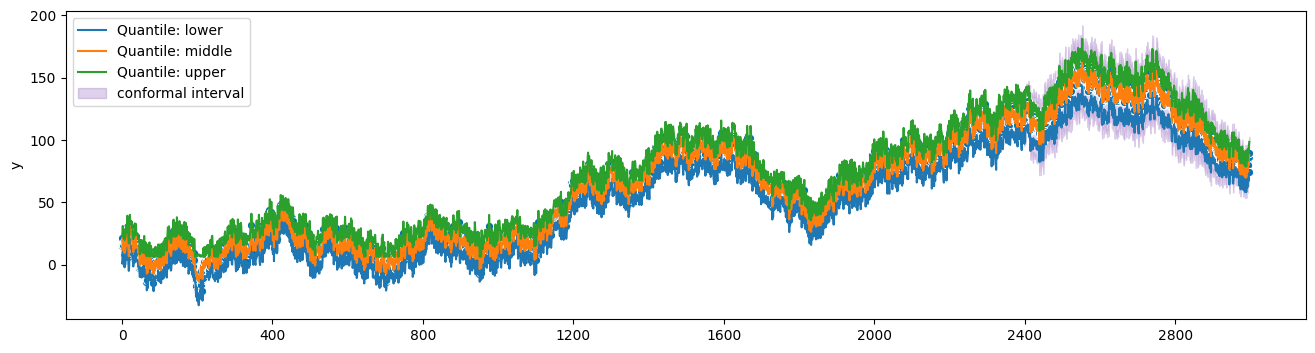

In [51]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[1] = metric.computeAll(model_name="NN ACI").values()

<Figure size 640x480 with 0 Axes>

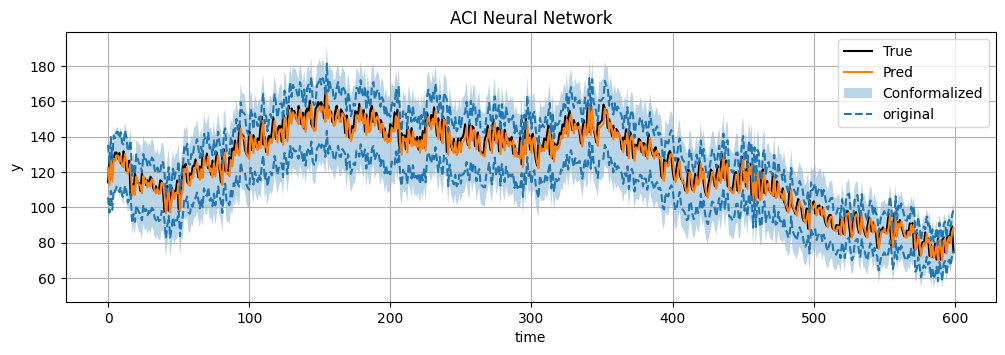

In [52]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Neural Network')

EnbPI

In [53]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.5], n_inputs=1, model_params=model)

In [54]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])

bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [55]:
batch = pd.DataFrame({"y_lag" : bs_train_data[0][0][:,0], "y": bs_train_data[0][1].flatten()})

In [56]:
from IPython.utils import io

In [57]:
model = qrnn

# this is to hide the training logs
with io.capture_output() as captured:
    bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

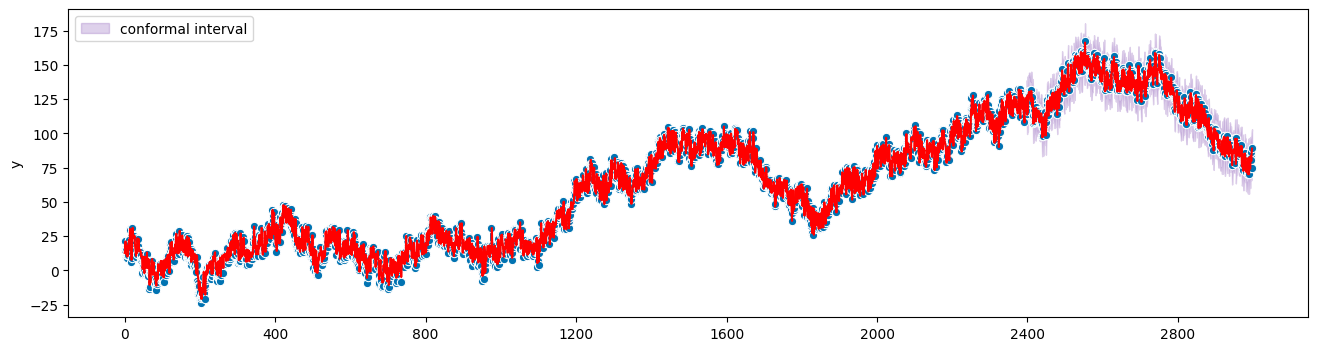

In [58]:
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[2] = metric.computeAll(model_name="NN EnbPI").values()

<Figure size 640x480 with 0 Axes>

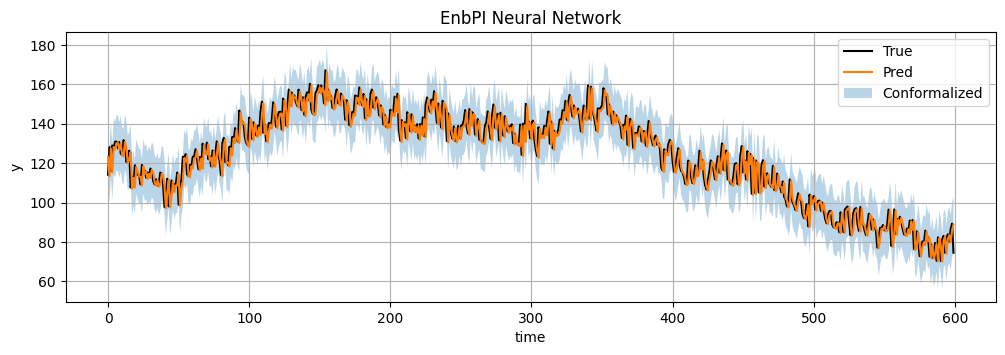

In [59]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Neural Network')

EnCQR

In [60]:
encqr = EnCQR(n_ensembles=10, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [61]:
layers = 2
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.05, 0.5, 0.95], n_inputs=1, model_params=model)

In [62]:
model = qrnn
epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Output()

Training model for Sb: 0 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         5.584        
      2   0.0005         5.685        
      3   0.0005         5.450        
      4   0.0005         5.593        
      5   0.0005         4.919        
      6   0.0005         5.366        
      7   0.0005         5.266        
      8   0.0005         4.919        
      9   0.0005         4.585        
     10   0.0005         4.584        
     11   0.0005         4.302        
     12   0.0005         4.068        
     13   0.0005         4.046        
     14   0.0005         4.192        
     15   0.0005         3.719

Output()

Training model for Sb: 1 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         7.131        
      2   0.0005         6.775        
      3   0.0005         6.585        
      4   0.0005         6.327        
      5   0.0005         5.806        
      6   0.0005         5.070        
      7   0.0005         5.718        
      8   0.0005         5.097        
      9   0.0005         4.690        
     10   0.0005         4.648        
     11   0.0005         4.335        
     12   0.0005         3.969        
     13   0.0005         3.846        
     14   0.0005         3.275        
     15   0.0005         3.284

Output()

Training model for Sb: 2 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         2.631        
      2   0.0005         2.405        
      3   0.0005         2.251        
      4   0.0005         1.992        
      5   0.0005         2.214        
      6   0.0005         2.021        
      7   0.0005         1.964        
      8   0.0005         1.864        
      9   0.0005         2.001        
     10   0.0005         1.703        
     11   0.0005         1.931        
     12   0.0005         1.743        
     13   0.0005         1.828        
     14   0.0005         1.746        
     15   0.0005         1.845

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.706        
      2   0.0005         1.767        
      3   0.0005         1.642        
      4   0.0005         1.394        
      5   0.0005         1.535        
      6   0.0005         1.636        
      7   0.0005         1.770        
      8   0.0005         1.542        
      9   0.0005         1.556        
     10   0.0005         1.609        
     11   0.0005         1.523        
     12   0.0005         1.557        
     13   0.0005         1.674        
     14   0.0005         1.730        
     15   0.0005         1.484

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.532        
      2   0.0005         1.607        
      3   0.0005         1.487        
      4   0.0005         1.506        
      5   0.0005         1.578        
      6   0.0005         1.659        
      7   0.0005         1.356        
      8   0.0005         1.638        
      9   0.0005         1.596        
     10   0.0005         1.492        
     11   0.0005         1.484        
     12   0.0005         1.483        
     13   0.0005         1.569        
     14   0.0005         1.519        
     15   0.0005         1.538

Output()

Training model for Sb: 5 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         2.046        
      2   0.0005         1.884        
      3   0.0005         1.953        
      4   0.0005         1.902        
      5   0.0005         1.721        
      6   0.0005         1.731        
      7   0.0005         1.745        
      8   0.0005         1.578        
      9   0.0005         1.564        
     10   0.0005         1.517        
     11   0.0005         1.549        
     12   0.0005         1.500        
     13   0.0005         1.509        
     14   0.0005         1.569        
     15   0.0005         1.533

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.379        
      2   0.0005         1.478        
      3   0.0005         1.385        
      4   0.0005         1.425        
      5   0.0005         1.379        
      6   0.0005         1.421        
      7   0.0005         1.476        
      8   0.0005         1.380        
      9   0.0005         1.345        
     10   0.0005         1.457        
     11   0.0005         1.427        
     12   0.0005         1.339        
     13   0.0005         1.406        
     14   0.0005         1.267        
     15   0.0005         1.398

Output()

Training model for Sb: 7 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.681        
      2   0.0005         1.628        
      3   0.0005         1.499        
      4   0.0005         1.526        
      5   0.0005         1.459        
      6   0.0005         1.547        
      7   0.0005         1.578        
      8   0.0005         1.440        
      9   0.0005         1.499        
     10   0.0005         1.618        
     11   0.0005         1.603        
     12   0.0005         1.566        
     13   0.0005         1.455        
     14   0.0005         1.633        
     15   0.0005         1.658

Output()

Training model for Sb: 8 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.721        
      2   0.0005         1.560        
      3   0.0005         1.604        
      4   0.0005         1.586        
      5   0.0005         1.528        
      6   0.0005         1.542        
      7   0.0005         1.529        
      8   0.0005         1.395        
      9   0.0005         1.534        
     10   0.0005         1.483        
     11   0.0005         1.451        
     12   0.0005         1.504        
     13   0.0005         1.564        
     14   0.0005         1.465        
     15   0.0005         1.545

Output()

Training model for Sb: 9 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.812        
      2   0.0005         1.656        
      3   0.0005         1.624        
      4   0.0005         1.519        
      5   0.0005         1.645        
      6   0.0005         1.629        
      7   0.0005         1.687        
      8   0.0005         1.646        
      9   0.0005         1.538        
     10   0.0005         1.600        
     11   0.0005         1.524        
     12   0.0005         1.645        
     13   0.0005         1.497        
     14   0.0005         1.553        
     15   0.0005         1.609

In [63]:
test_label = df_test["y"].to_numpy()

In [64]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2
Creating test predictions for Sb 3
Creating test predictions for Sb 4
Creating test predictions for Sb 5
Creating test predictions for Sb 6
Creating test predictions for Sb 7
Creating test predictions for Sb 8
Creating test predictions for Sb 9


In [65]:
conf_PI.shape

(600, 1, 3)

In [66]:
# # Plot original and conformalized PI
# encqr.plot_PIs(test_y, PI[:,:,1],
#                PI[:,:,0], PI[:,:,2],
#                conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

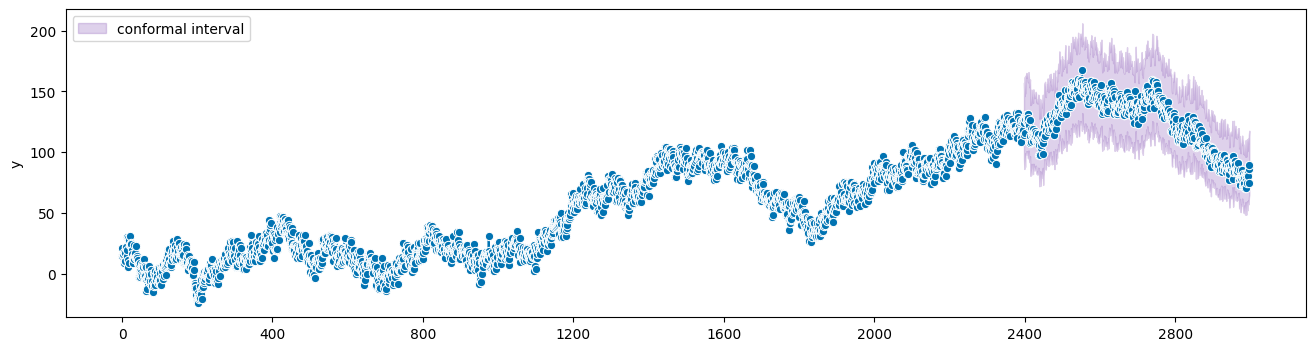

In [67]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_NN.loc[3] = metric.computeAll(model_name="NN EnCQR").values()

<Figure size 640x480 with 0 Axes>

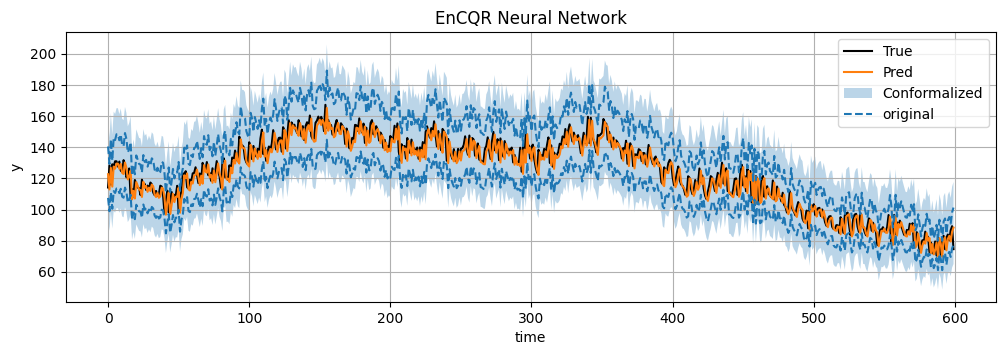

In [68]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Neural Network')

In [69]:
df_NN

model_name      RMSE      PICP       PIAW     PINAW       CWC
0     NN CQR  7.120784  0.943333  31.754955  0.328017  0.635174
1     NN ACI  7.120784  0.996667  49.917381  0.515628  0.365958
2   NN EnbPI  7.025388  0.948333  28.277217  0.292093  0.659993
3   NN EnCQR  7.103059  1.000000  62.442480  0.645008  0.262984

# Comparison

## Tables

In [70]:
df_arima.to_csv(f"{dataset}_arima_500.csv")
df_arima

In [71]:
df_linear.to_csv(f"{dataset}_linear_500.csv")

In [72]:
df_forest.to_csv(f"{dataset}_forest_500.csv")

In [73]:
df_NN.to_csv(f"{dataset}_NN_500.csv")

GRID SEARCH

In [74]:
# scores_lin, gamma_lin = optimize_conformal(model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [75]:
# scores_rf, gamma_rf = optimize_conformal(model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [76]:
# scores_nn, gamma_nn = optimize_conformal(model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)